In [21]:
# Import the necessary libraries and functions for this demo
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import GradientBoostingRegressor
from dowhy.gcm.falsify import FalsifyConst, falsify_graph, plot_local_insights, run_validations, apply_suggestions
from dowhy.gcm.independence_test.generalised_cov_measure import generalised_cov_based
from dowhy.gcm.util import plot
from dowhy.gcm.util.general import set_random_seed
from dowhy.gcm.ml import SklearnRegressionModel
from dowhy.gcm.util.general import set_random_seed
set_random_seed(0)

# Set random seed
set_random_seed(1332)

In [49]:
import pandas as pd
import networkx as nx

# Step 1: Load data
df = pd.read_csv("/Users/paulfagan/Downloads/masters_daily_level_dataset_rev50.csv")

# Step 2: Define and save your graph
true_causal_graph = nx.DiGraph([
    ('spend_TV', 'spend_Facebook'),
    ('spend_TV', 'spend_Search'),
    ('spend_Facebook', 'spend_Search'),
    ('spend_Facebook', 'total_revenue'),
    ('spend_Search', 'total_revenue'),
    ('spend_TV', 'total_revenue')
])
nx.write_gml(true_causal_graph, "falsify_g_true.gml")

# Step 3: Read graph from file
g_true = nx.read_gml("falsify_g_true.gml")

# Step 4: Optional – Print node alignment
print("Graph nodes:", g_true.nodes())
print("DF columns:", df.columns.tolist())

# Step 5: Run falsification (assumes your method exists and uses df + graph)
result = falsify_graph(g_true, df, plot_histogram=True)

# Step 6: Summary
print(result)

Graph nodes: ['spend_TV', 'spend_Facebook', 'spend_Search', 'total_revenue']
DF columns: ['DATE', 'total_revenue', 'impressions_Facebook', 'impressions_TV', 'clicks_Search', 'spend_Facebook', 'spend_TV', 'spend_Search']


Test permutations of given graph: 100%|███████| 20/20 [00:00<00:00, 1401.65it/s]

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| Cannot be evaluated!                                                                                  |
+-------------------------------------------------------------------------------------------------------+


In [50]:
print(f"N_TESTS: {result.summary[FalsifyConst.VALIDATE_LMC][FalsifyConst.N_TESTS]}")
print(f"Available methods: {list(result.summary.keys())}")

N_TESTS: 0
Available methods: [<FalsifyConst.VALIDATE_LMC: 11>, <FalsifyConst.VALIDATE_TPA: 12>, <FalsifyConst.MEC: 16>]


In [37]:
print(f"Graph is falsifiable: {result.falsifiable}, Graph is falsified: {result.falsified}")


Graph is falsifiable: False, Graph is falsified: False


Test permutations of given graph: 100%|█████████| 20/20 [00:15<00:00,  1.31it/s]


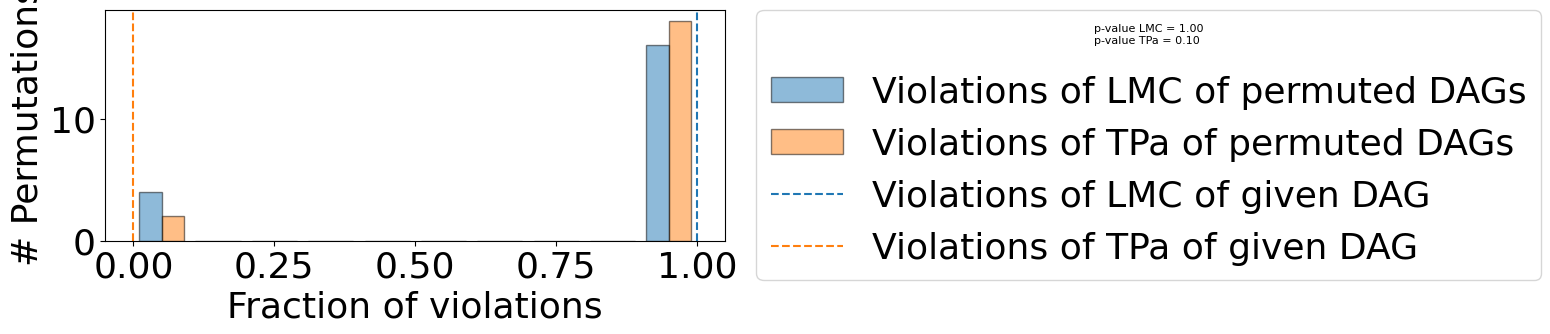

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is not informative because 2 / 20 of the permutations lie in the Markov                 |
| equivalence class of the given DAG (p-value: 0.10).                                                   |
| The given DAG violates 2/2 LMCs and is better than 0.0% of the permuted DAGs (p-value: 1.00).         |
| Based on the provided significance level (0.05) and because the DAG is not informative,               |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [36]:
g_simplified = true_causal_graph.copy()
g_simplified.remove_edge('spend_Facebook', 'spend_Search')


result = falsify_graph(g_simplified, df, plot_histogram=True)
print(result)

In [47]:
def simplify_dag(g_original, data, max_remove=2, top_k=3, verbose=True):
    from itertools import combinations
    candidates = []
    edges = list(g_original.edges())

    for r in range(1, max_remove + 1):
        for edges_to_remove in combinations(edges, r):
            g_mod = g_original.copy()
            g_mod.remove_edges_from(edges_to_remove)

            try:
                result = falsify_graph(g_mod, data, plot_histogram=False)

                if verbose:
                    print(f"\nTested removal {edges_to_remove}")
                    print(f"→ Violations: {result.local_markov_condition_result.given_violations}")
                    print(f"→ Falsified: {result.falsified}")
                    print(f"→ MEC size: {len(result.markov_equivalence_class)}")

                candidates.append((g_mod, result))

            except Exception as e:
                if verbose:
                    print(f"Failed on removal {edges_to_remove}: {e}")

    ranked = sorted(
        candidates,
        key=lambda x: (
            len(x[1].markov_equivalence_class),               # prefer smaller MEC (more informative)
            x[1].falsified,                                    # prefer not falsified
            x[1].local_markov_condition_result.given_violations  # prefer fewer violations
        )
    )

    return ranked[:top_k]

In [48]:
from networkx import read_gml

data = pd.read_csv("/Users/paulfagan/Downloads/masters_daily_level_dataset_rev50.csv")

# Simplify
top_dags = simplify_dag(g_true, data, max_remove=2, top_k=1)

# Best result
best_graph, best_result = top_dags[0]
print(best_result.summary())

# Optional: visualize or save
nx.write_gml(best_graph, "falsified_best_dag.gml")


Test permutations of given graph: 100%|█████████| 20/20 [00:09<00:00,  2.01it/s]



Tested removal (('spend_TV', 'spend_Facebook'),)
Failed on removal (('spend_TV', 'spend_Facebook'),): 'EvaluationResult' object has no attribute 'local_markov_condition_result'


Test permutations of given graph:  70%|██████▎  | 14/20 [00:25<00:10,  1.83s/it]


KeyboardInterrupt: 

In [6]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
beta = 100
data_dict = dowhy.datasets.xy_dataset(10000, effect=beta,
                                      num_common_causes=5,
                                      is_linear= False,
                                      num_frontdoor_variables=1,
                                      sd_error=0.2)
df = data_dict['df']
print(df.head())
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])

TypeError: xy_dataset() got an unexpected keyword argument 'num_frontdoor_variables'

In [16]:
# Creating a dataset with a single confounder and a single mediator (num_frontdoor_variables)
data = dowhy.datasets.linear_dataset(10, num_common_causes=20, num_samples=10000,
                                     num_instruments=0, num_effect_modifiers=0,
                                     num_treatments=1,
                                     num_frontdoor_variables=1,
                                     treatment_is_binary=False,
                                    outcome_is_binary=False)
df = data['df']
print(df.head())

          FD0        W0        W1        W2        W3        W4        W5  \
0  -80.608111 -1.335898 -1.194146 -0.258696  0.385697  0.229471 -2.829677   
1  -18.167101 -0.242193  0.631238  1.104555  0.695290  0.057201  1.006707   
2  -72.463578  0.612134  0.389768  1.839531  0.239325 -0.524737 -0.410646   
3  132.133230 -1.941501  1.049556  0.268912  0.093851 -2.232785 -0.937604   
4  102.101164 -0.992055 -0.770708  0.403349  0.080944 -0.906946 -2.083607   

         W6        W7        W8  ...       W12       W13       W14       W15  \
0 -0.619507  0.563650  1.003703  ... -0.206063  0.585939  0.425102 -1.685415   
1  0.881433  0.760673 -1.584644  ... -1.776783  0.250107 -0.688308 -0.155034   
2  0.212409  0.462145 -0.361616  ...  0.075740 -1.041696 -0.653792  0.812870   
3  3.540306  0.647894 -0.342486  ...  0.239223  0.071644  0.098250 -0.656044   
4  1.102584  0.602172  0.874442  ...  0.241843  0.812119  0.523872  0.985361   

        W16       W17       W18       W19         v0    

In [20]:
help(dowhy.datasets.linear_dataset)

Help on function linear_dataset in module dowhy.datasets:

linear_dataset(beta, num_common_causes, num_samples, num_instruments=0, num_effect_modifiers=0, num_treatments=None, num_frontdoor_variables=0, treatment_is_binary=True, treatment_is_category=False, outcome_is_binary=False, stochastic_discretization=True, num_discrete_common_causes=0, num_discrete_instruments=0, num_discrete_effect_modifiers=0, stddev_treatment_noise=1, stddev_outcome_noise=0.01, one_hot_encode=False)
    Generate a synthetic dataset with a known effect size.
    
    This function generates a pandas dataFrame with num_samples records. The variables follow a naming convention where the first letter indicates its role in the causality graph and then a sequence number.
    
    :param beta: coefficient of the treatment(s) ('v?') in the generating equation of the outcome ('y').
    :type beta: int or list/ndarray of length num_treatments of type int
    :param num_common_causes: Number of variables affecting both 

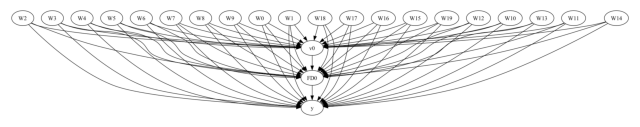

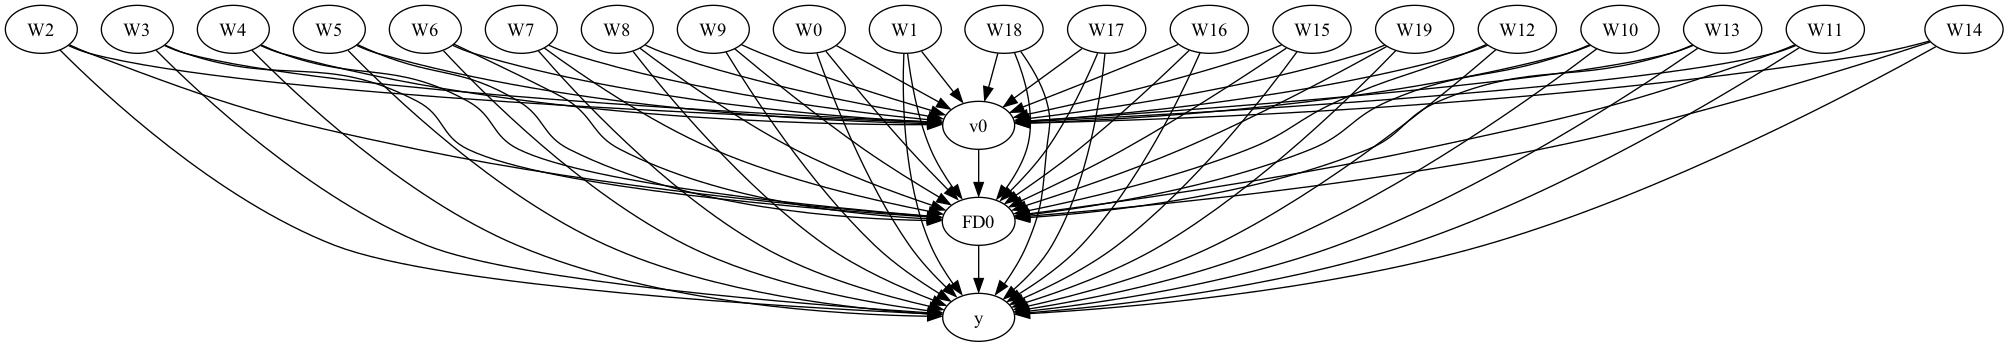

In [17]:
model = CausalModel(df,
                    data["treatment_name"],data["outcome_name"],
                    data["gml_graph"],
                   missing_nodes_as_confounders=True)

model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                            ↪
─────(E[y|W6,W0,W10,W19,W11,W4,W18,W15,W17,W12,W16,W5,W13,W8,W2,W9,W14,W3,W7,W ↪
d[v₀]                                                                          ↪

↪    
↪ 1])
↪    
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W6,W0,W10,W19,W11,W4,W18,W15,W17,W12,W16,W5,W13,W8,W2,W9,W14,W3,W7,W1,U) = P(y|v0,W6,W0,W10,W19,W11,W4,W18,W15,W17,W12,W16,W5,W13,W8,W2,W9,W14,W3,W7,W1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                            ↪
─────(E[y|W6,W0,W10,W19,W11,W4,W18,W15,W17,W12,W16,W5,W13,W8,W2,W9,W14,W3,W7,W ↪
d[v₀]                                                                          ↪

↪    
↪ 1])
↪    
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W6,W0,W10,W19,W11,W4,W18,W15,W17,W12,W16,W5,W13,W8,W2,W9,W14,W3,W7,W1,U) = P(y|v0,W6,W0,W10,W19,W11,W4,W18,W15,W17,W12,W16,W5,W13,W8,W2,W9,W14,W3,W7,W1)

## Realized estimand
b: y~v0+W6+W0+W10+W19+W11+W4+W18+W15+W17+W12+W16+W5+W13+W8+W2+W9+W14+W3+W7+W1
Target units: ate

## Estimate
Mean value: 6.6651956016871186

Causal Estimate is 6.6651956016871186


KeyError: 'Treatment'